In [209]:
from selenium import webdriver
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC 
from selenium.webdriver.common.by import By
from selenium.webdriver import Chrome
from webdriver_manager.chrome import ChromeDriverManager
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.chrome.options import Options
import json
from os.path import isfile
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import MultiLabelBinarizer


WebScrapper

In [210]:
def startDriver(url:str) -> webdriver.Chrome:
	service = Service(ChromeDriverManager().install())
	options = Options()
	options.add_argument("--disable-extensions")
	options.add_argument("--headless")
	driver = Chrome(service=service, options=options)

	driver.get(f"{url}")
	
	WebDriverWait(driver, 20).until(EC.element_to_be_clickable((By.CSS_SELECTOR, "button.align-right.secondary.slidedown-button"))).click()
	WebDriverWait(driver, 20).until(EC.element_to_be_clickable((By.CSS_SELECTOR, "button.banner__close.privacy__banner"))).click()
	WebDriverWait(driver, 5).until(EC.element_to_be_clickable((By.CSS_SELECTOR, "button.spirit-family-select__button.js-select-spirit-family.all.selected"))).click()
	WebDriverWait(driver, 5).until(EC.element_to_be_clickable((By.CSS_SELECTOR, 'button[data-value="agave"]'))).click()
	return driver

In [211]:
def extractLinks(url:str) -> list: 
    
    driver = startDriver(url)

    hrefs = []

    for x in range(1, 51):
        driver.get(f"{url}{x}")
        elements = driver.find_elements(By.CSS_SELECTOR, "li.spirit.agave-content")
        for element in elements:
            hrefs.append(element.find_element(By.TAG_NAME, "a").get_attribute("href"))
   
    driver.quit()

    return hrefs

In [212]:
def extractProductDetails(hrefs:list, url:str) -> pd.DataFrame:
    
    df = pd.DataFrame(columns=['name', 'type', 'cask', 'location', 'age', 'abv %', 'cost', 
    'badge', '# ratings', "community rating", 'flavor summary', 'expert', 
    'expert score', 'smoky', 'earthy', 'spicy', 'herbal', 'oily', 'bitter', 
    'rich', 'sweet', 'mineral', 'salty', 'umami', 'tart', 'fruity', 
    'floral'])

    driver = startDriver(url)

    for href in hrefs:
        driver.get(href)
        
        #Nombre
        try:
            name = driver.find_element(By.XPATH, "/html/body/div[7]/div/div/main/div/div[1]/div[1]/div[3]/h1").text
            if name == "":
                name = "unknown"
        except:
            name = "unknown"
        #Tipo

        try:   
            types = driver.find_element(By.XPATH,"/html/body/div[7]/div/div/main/div/div[1]/div[1]/div[3]/div/p[1]").text
            if types == "":
                types = pd.NA
        except:
            types = pd.NA
        #Cask
        try:
            cask = driver.find_element(By.XPATH,"/html/body/div[7]/div/div/main/div/div[1]/div[2]/div[1]/div/div/div[2]/div[3]/ul/li[3]/div[2]").text
            if cask == "":
                cask = "unknown"    
        except:
            cask = "unknown"
        #Location y badge

        try:
            temp = driver.find_element(By.XPATH,"/html/body/div[7]/div/div/main/div/div[1]/div[1]/div[3]/div/p[2]").text.split("// ")

            location = temp[1]
            badge = temp[0]

            if location == "":
                location = "unknown"
            if badge == "":
                badge = "unknown"
        except:
            location = "unknown"
            badge = "unknown"

        #age

        try:
            age = driver.find_element(By.XPATH,"/html/body/div[7]/div/div/main/div/div[1]/div[2]/div[1]/div/div/div[2]/div[3]/ul/li[1]/ul/li[1]/div[2]").text
            if age == "":
                age = "unknown"
        except:
            age = "unknown"

        #ABV
        try:
            abv = driver.find_element(By.XPATH,"/html/body/div[7]/div/div/main/div/div[1]/div[2]/div[1]/div/div/div[2]/div[3]/ul/li[1]/ul/li[3]/div[2]").text
            if abv == "":
                abv = pd.NA 
        except:
            abv = pd.NA

        #Cost
        try:
            cost = driver.find_element(By.XPATH, "/html/body/div[7]/div/div/main/div/div[1]/div[2]/div[1]/div/div/div[2]/div[3]/ul/li[1]/ul/li[2]/div[2]/div").get_attribute("class")[-1]
            if cost == "":  
                cost = pd.NA
        except:
            cost = pd.NA

        #Ratings
        try:
            ratings = driver.find_element(By.XPATH,"/html/body/div[7]/div/div/main/div/div[1]/div[2]/div[1]/div/div/div[1]/div/div/div/div/div[3]/a/span[2]").text
            if ratings == "":
                ratings = "unknown"
        except:
            ratings = "unknown"

        #Community Rating
        try:
            community_rating = driver.find_element(By.XPATH,"/html/body/div[7]/div/div/main/div/div[1]/div[2]/div[1]/div/div/div[1]/div/div/div/div/div[1]/span").text
            if community_rating == "" or community_rating == "No one has reviewed this yet. Be the first":
                community_rating = "unknown"
        except:
            community_rating = "unknown"

        #Flavor Summary
        try:
            flavor_summary = driver.find_element(By.XPATH,"/html/body/div[7]/div/div/main/div/div[1]/div[2]/div[1]/div/div/div[5]/h3").text
            if flavor_summary == "":
                flavor_summary = "unknown"
        except:
            flavor_summary = "unknown"  

        #Expert
        try:
            expert = driver.find_element(By.XPATH,"/html/body/div[7]/div/div/main/div/div[1]/div[2]/div[1]/div/div/div[3]/div[2]/div[1]/a").text
            if expert == "":
                expert = "unknown"
        except:
            expert = "unknown"

        #Expert Score
        try:
            expert_score = driver.find_element(By.XPATH,"/html/body/div[7]/div/div/main/div/div[1]/div[2]/div[1]/div/div/div[3]/div[2]/div[2]/span").text
            if expert_score == "":
                expert_score = "unknown"
        except:
            expert_score = "unknown"
        

        #Flavor Profile
        try:
            canvas_element = driver.find_element(By.XPATH, "/html/body/div[7]/div/div/main/div/div[1]/div[2]/div[1]/div/div/div[5]/canvas")
            data_flavors = canvas_element.get_attribute("data-flavors")
            df_2 = pd.DataFrame([json.loads(data_flavors)])
        except:
            df_2 = pd.DataFrame([{
                'smoky': pd.NA,
                'earthy': pd.NA,
                'spicy': pd.NA,
                'herbal': pd.NA,
                'oily': pd.NA,
                'bitter': pd.NA,
                'rich': pd.NA,
                'sweet': pd.NA,
                'mineral': pd.NA,
                'salty': pd.NA,
                'umami': pd.NA,
                'tart': pd.NA,
                'fruity': pd.NA,
                'floral': pd.NA
            }])

        #Create df_1
        df_1 = {
            'name': name,
            'type': types,
            'cask': cask,
            'location': location,
            'age': age,
            'abv %': abv,
            'cost': cost,
            'badge': badge,
            '# ratings': ratings,
            'community rating': community_rating,
            'flavor summary': flavor_summary,
            'expert': expert,
            'expert score': expert_score
        }

        df_1 = pd.DataFrame([df_1])
        

        #Concatenate df_1 and df_2
        df_1 = pd.concat([df_1, df_2], axis=1)

        #Append to df
        df = pd.concat([df, df_1], ignore_index=True)

    return df

In [213]:
def get_df() -> pd.DataFrame:
    url = "https://distiller.com/search?page="
    hrefs = extractLinks(url)
    df = extractProductDetails(hrefs, url)

    df = df.dropna()
    df.to_csv("distiler.csv", index=False)
    return df


In [214]:
if not isfile("distiler.csv"):
    get_df().to_csv("distiler.csv", index=False)

In [215]:
data = pd.read_csv("distiler.csv")

In [216]:
data["cask"].fillna("Unknown", inplace=True)
data["abv %"].fillna(data["abv %"].median(), inplace=True)

print("\nValores faltantes después de limpieza:")
print(data.isnull().sum())


Valores faltantes después de limpieza:
name                0
type                0
cask                0
location            0
age                 0
abv %               0
cost                0
badge               0
# ratings           0
community rating    0
flavor summary      0
expert              0
expert score        0
smoky               0
earthy              0
spicy               0
herbal              0
oily                0
bitter              0
rich                0
sweet               0
mineral             0
salty               0
umami               0
tart                0
fruity              0
floral              0
dtype: int64


In [217]:
# Trasformacion de flavor summary a lista
data[['flavor summary 1', 'flavor summary 2']] = data['flavor summary'].str.split('&', expand=True)
data['flavor summary 1'] = data['flavor summary 1'].str.strip()  
data['flavor summary 2'] = data['flavor summary 2'].str.strip()
data['flavor summary 2'].fillna(data['flavor summary 1'], inplace=True)
data['flavor summary'] = data[['flavor summary 1','flavor summary 2']].values.tolist()
data.drop(columns=['flavor summary 1', 'flavor summary 2'], inplace=True)

In [218]:
# Seleccion de datos para el modelo

# Los posibles predictores son: 'type', 'abv %', 'cost', '# ratings', 'community rating', 'expert score', 'flavor summary', 'smoky', 'earthy', 'spicy', 'herbal', 
# 'oily', 'bitter', 'rich', 'sweet', 'mineral', 'salty', 'umami', 'tart', 'fruity', 'floral', 'Expert'
# Descardado los demas predictores por no ser relevantes o tener demaciados valores faltantes

# Variable cualitativa diponible: 'type', 'flavor summary', 'Expert'

def get_df_predictors(predictors: list) -> pd.DataFrame:

    data_cleaned = data[predictors]

    try:
        mlb = MultiLabelBinarizer()
        one_hot_encoded = pd.DataFrame(mlb.fit_transform(data_cleaned['flavor summary']), columns=mlb.classes_)
        data_cleaned = pd.concat([data_cleaned, one_hot_encoded], axis=1)
        data_cleaned.drop(columns=['flavor summary'], inplace=True)
    except:
        pass

    try:
        one_hot = pd.get_dummies(data_cleaned['type'], prefix='type')
        data_cleaned.drop('type', axis=1, inplace=True)
        data_cleaned = data_cleaned.join(one_hot)
    except:
        pass

    try:
        one_hot = pd.get_dummies(data_cleaned['Expert'], prefix='Expert')
        data_cleaned.drop('Expert', axis=1, inplace=True)
        data_cleaned = data_cleaned.join(one_hot)
    except:
        pass
        
    data_cleaned = data_cleaned.replace('unknown', pd.NA)
    data_cleaned.dropna(inplace=True)

    

    
    return data_cleaned

In [219]:
predictors = ['type', 'abv %', 'cost', '# ratings', 'community rating', 'expert score', 'smoky', 'earthy', 'spicy', 'herbal', 
 'oily', 'bitter', 'rich', 'sweet', 'mineral', 'salty', 'umami', 'tart', 'fruity', 'floral']
data_cleaned = get_df_predictors(predictors)
data_cleaned.to_csv("data.csv", index=False)

C:\Users\benji\AppData\Local\Temp\ipykernel_17296\1504148870.py:23: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Importacion de datos

In [220]:
data = pd.read_csv("data.csv")

### Reducción de Dimensionalidad 

Aplicar PCA y t-SNE para reducir la dimensionalidad de los datos. Visualizar los datos en 2D y 3D 
usando los componentes obtenidos. [15 puntos] 

PCA

In [221]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

import matplotlib.pyplot as plt

In [222]:
# Aplicar PCA
pca = PCA(n_components=3)
pca_result = pca.fit_transform(data)
pca

PCA(n_components=3)

Visualización 2D usando PCA

C:\Users\benji\AppData\Local\Temp\ipykernel_17296\862042004.py:6: UserWarning:

No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored

C:\Users\benji\AppData\Local\Temp\ipykernel_17296\862042004.py:12: UserWarning:

No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored

C:\Users\benji\AppData\Local\Temp\ipykernel_17296\862042004.py:18: UserWarning:

No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored



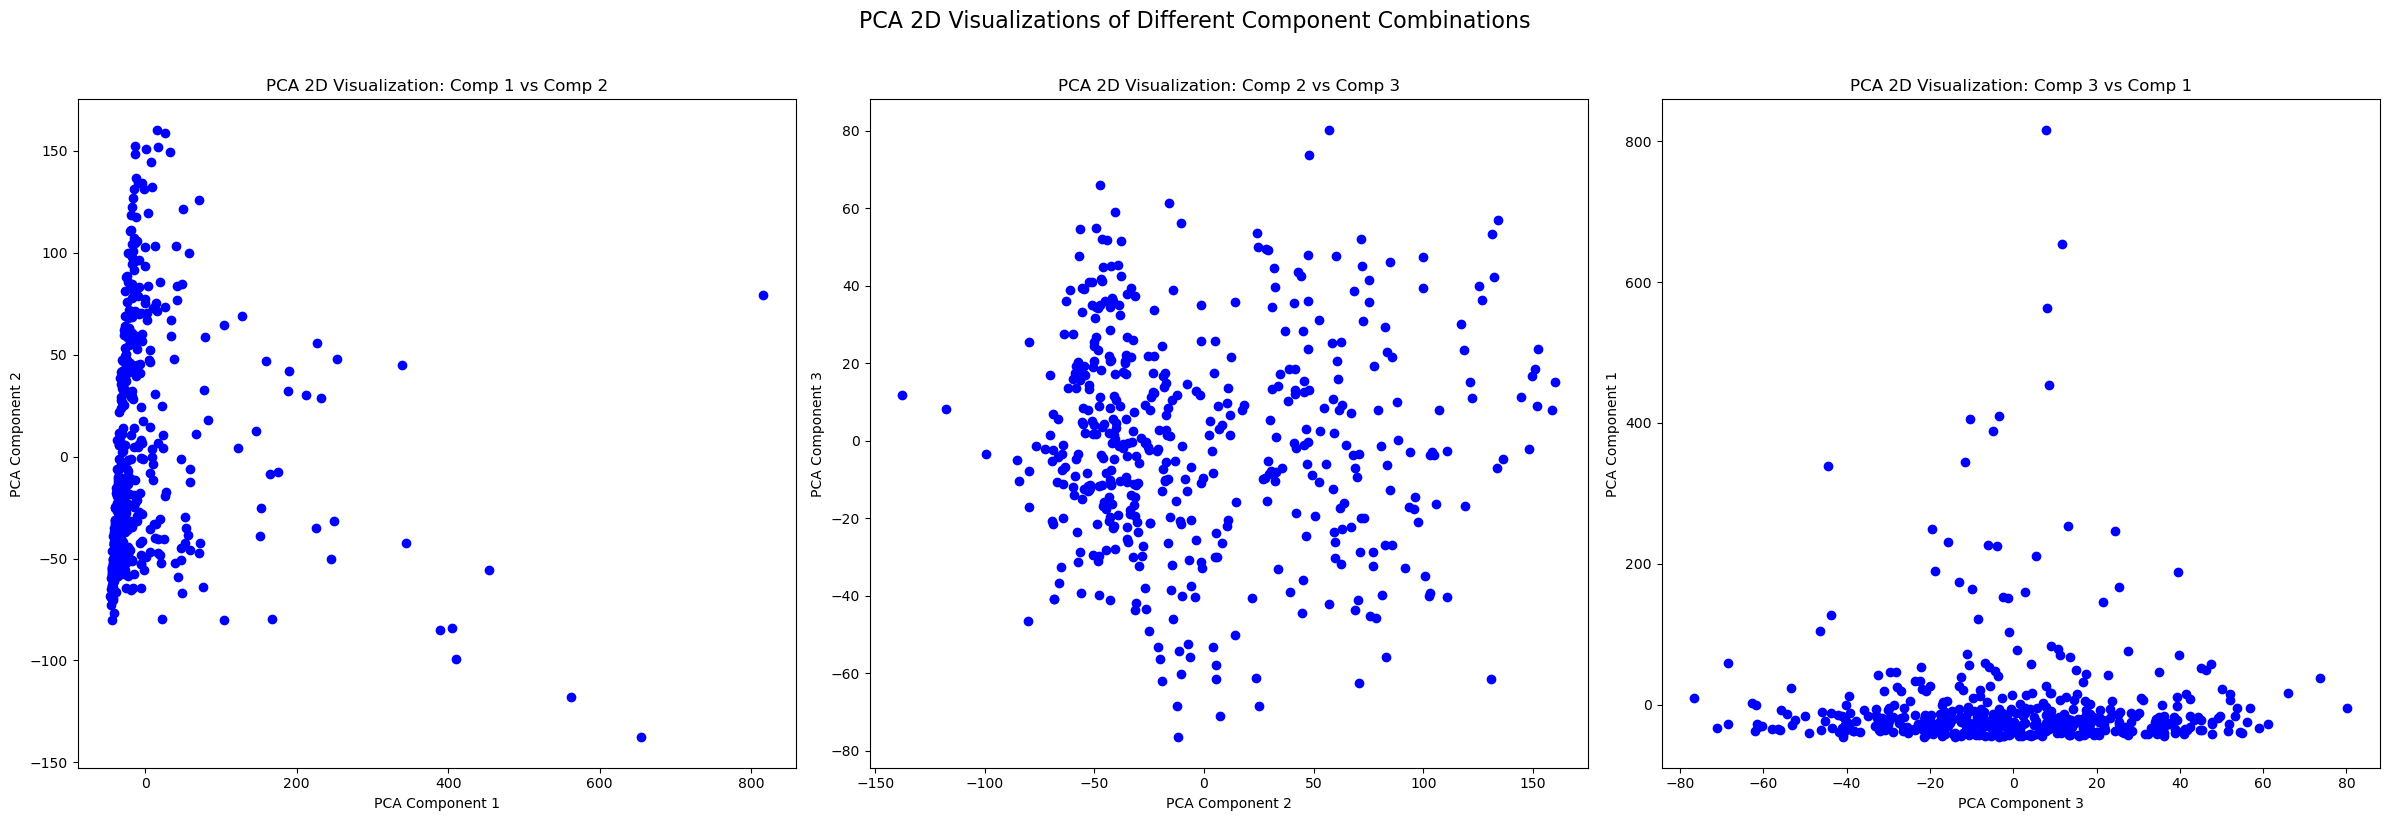

In [223]:
# Visualización 2D de los pca components
fig, axes = plt.subplots(1, 3, figsize=(24, 8))
fig.suptitle('PCA 2D Visualizations of Different Component Combinations', fontsize=16, y=1.02)

# Primer subplot
axes[0].scatter(pca_result[:, 0], pca_result[:, 1], c='blue', cmap='viridis')
axes[0].set_xlabel('PCA Component 1')
axes[0].set_ylabel('PCA Component 2')
axes[0].set_title('PCA 2D Visualization: Comp 1 vs Comp 2')

# Segundo subplot
axes[1].scatter(pca_result[:, 1], pca_result[:, 2], c='blue', cmap='viridis')
axes[1].set_xlabel('PCA Component 2')
axes[1].set_ylabel('PCA Component 3')
axes[1].set_title('PCA 2D Visualization: Comp 2 vs Comp 3')

# Tercer subplot
axes[2].scatter(pca_result[:, 2], pca_result[:, 0], c='blue', cmap='viridis')
axes[2].set_xlabel('PCA Component 3')
axes[2].set_ylabel('PCA Component 1')
axes[2].set_title('PCA 2D Visualization: Comp 3 vs Comp 1')

plt.tight_layout()


Visualizacion de los parametros 3D

C:\Users\benji\AppData\Local\Temp\ipykernel_17296\513151102.py:4: UserWarning:

No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored



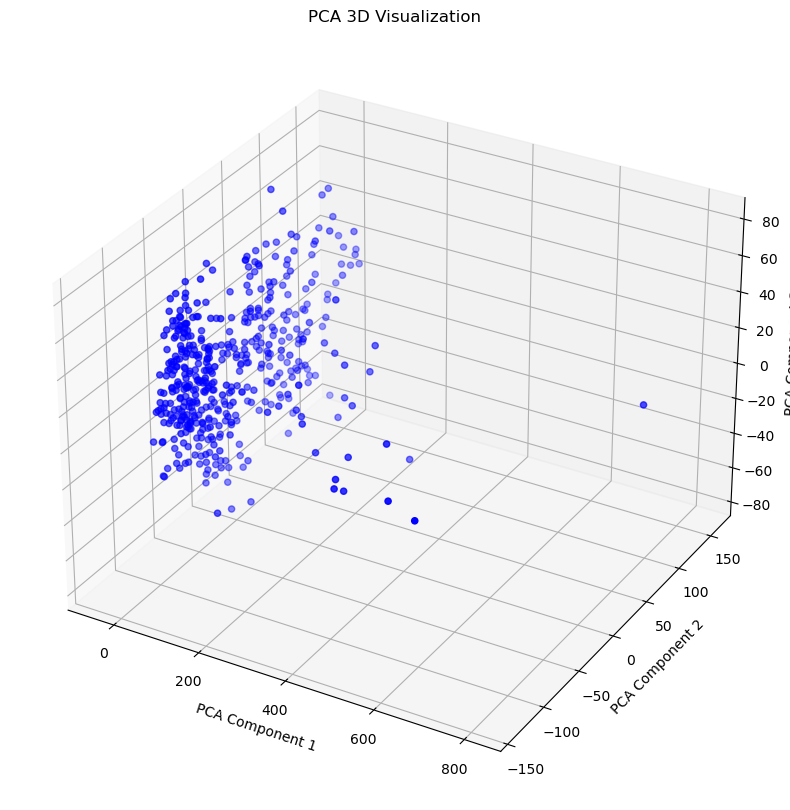

In [224]:
# Visualización 3D usando PCA
fig = plt.figure(figsize=(16,10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(pca_result[:, 0], pca_result[:, 1], pca_result[:, 2], c='blue', cmap='viridis')
ax.set_xlabel('PCA Component 1')
ax.set_ylabel('PCA Component 2')
ax.set_zlabel('PCA Component 3')
ax.set_title('PCA 3D Visualization')
plt.show()



Usando ploty

In [225]:
import plotly.graph_objects as go

# Crear el gráfico 3D interactivo
fig = go.Figure(data=[go.Scatter3d(
    x=pca_result[:, 0],  
    y=pca_result[:, 1],  
    z=pca_result[:, 2],  
    mode='markers',
    marker=dict(
        size=5,
        color=pca_result[:, 0],  
        colorscale='Viridis',  
        opacity=0.8
    )
)])

# Configurar etiquetas de los ejes y título
fig.update_layout(
    scene=dict(
        xaxis_title='PCA Component 1',
        yaxis_title='PCA Component 2',
        zaxis_title='PCA Component 3'
    ),
    title='PCA 3D Visualization',
    width=800,
    height=600
)

# Mostrar el gráfico
fig.show()


t-SNE

In [226]:
# Aplicar t-SNE
tsne = TSNE(n_components=3, perplexity=30, n_iter=300)
tsne_result = tsne.fit_transform(data)
tsne

TSNE(n_components=3, n_iter=300, perplexity=30)

C:\Users\benji\AppData\Local\Temp\ipykernel_17296\1270918115.py:6: UserWarning:

No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored

C:\Users\benji\AppData\Local\Temp\ipykernel_17296\1270918115.py:12: UserWarning:

No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored

C:\Users\benji\AppData\Local\Temp\ipykernel_17296\1270918115.py:18: UserWarning:

No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored



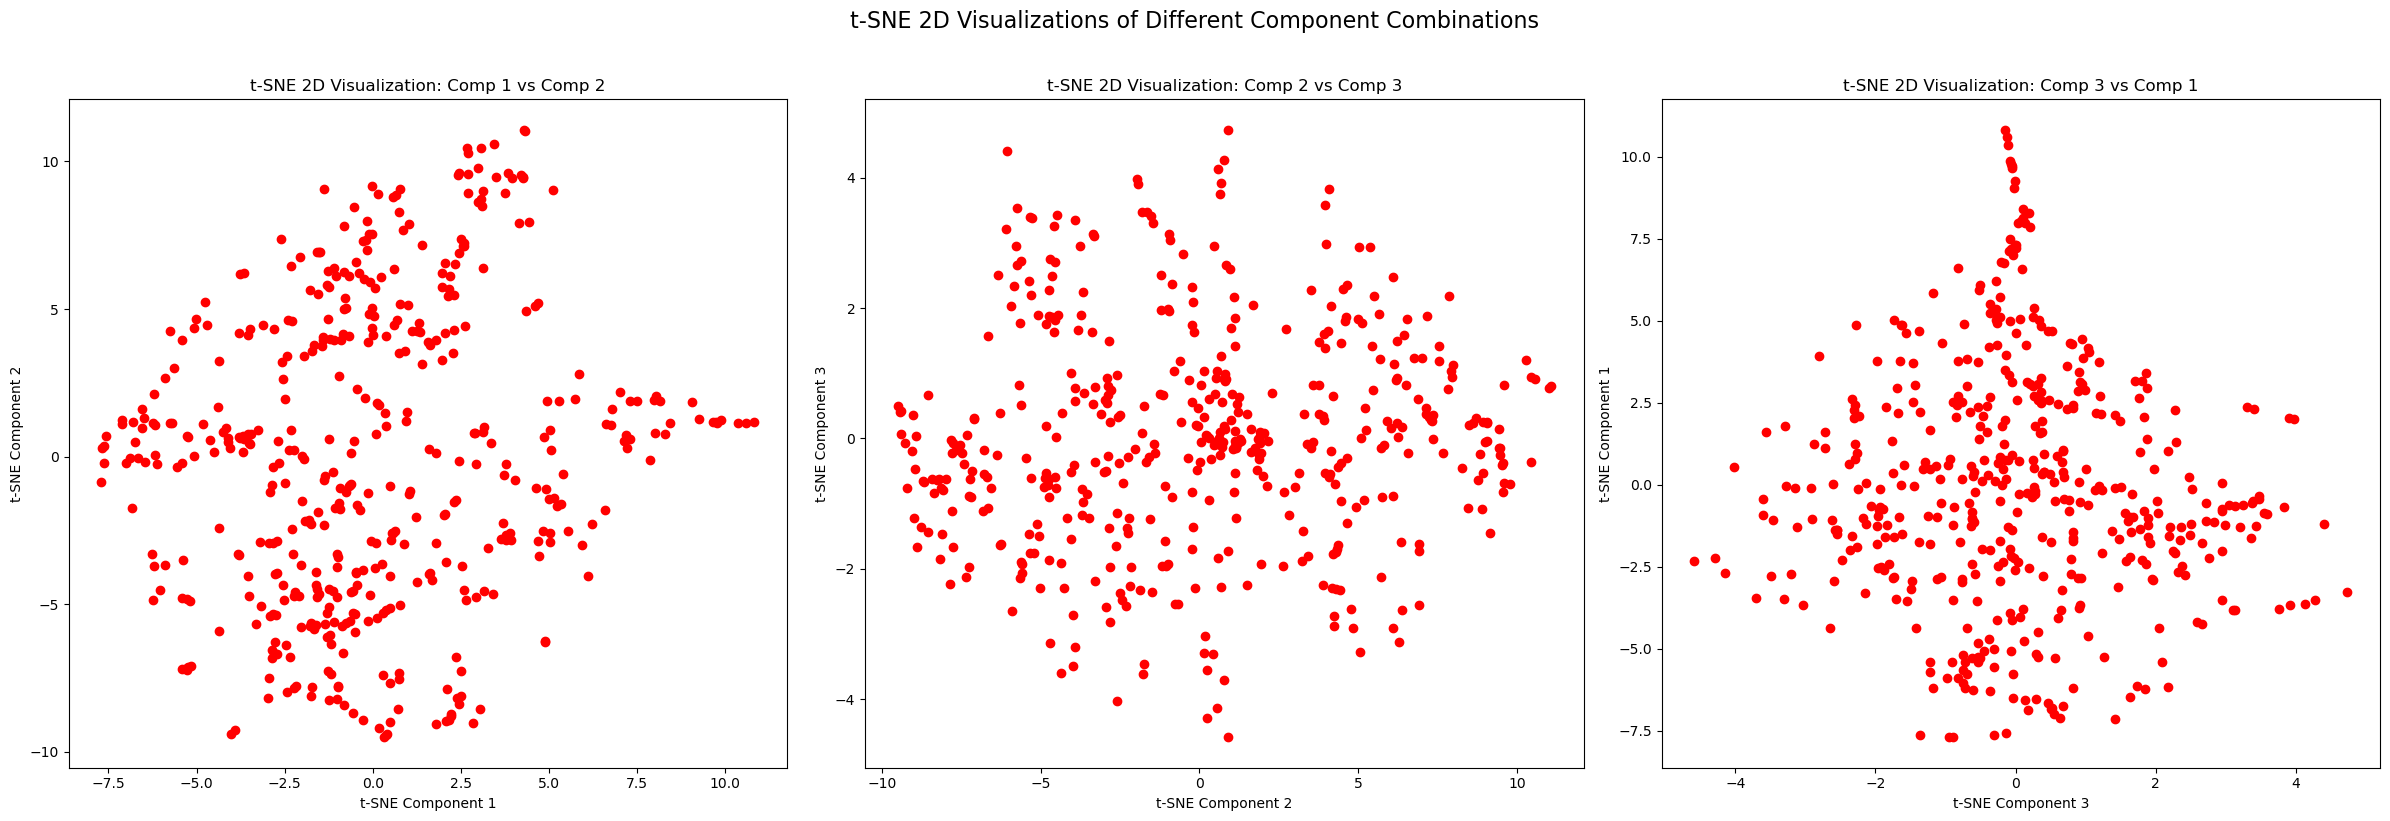

In [227]:
# Visualización 2D de los pca components
fig, axes = plt.subplots(1, 3, figsize=(24, 8))
fig.suptitle('t-SNE 2D Visualizations of Different Component Combinations', fontsize=16, y=1.02)

# Primer subplot
axes[0].scatter(tsne_result[:, 0], tsne_result[:, 1], c='red', cmap='viridis')
axes[0].set_xlabel('t-SNE Component 1')
axes[0].set_ylabel('t-SNE Component 2')
axes[0].set_title('t-SNE 2D Visualization: Comp 1 vs Comp 2')

# Segundo subplot
axes[1].scatter(tsne_result[:, 1], tsne_result[:, 2], c='red', cmap='viridis')
axes[1].set_xlabel('t-SNE Component 2')
axes[1].set_ylabel('t-SNE Component 3')
axes[1].set_title('t-SNE 2D Visualization: Comp 2 vs Comp 3')

# Tercer subplot
axes[2].scatter(tsne_result[:, 2], tsne_result[:, 0], c='red', cmap='viridis')
axes[2].set_xlabel('t-SNE Component 3')
axes[2].set_ylabel('t-SNE Component 1')
axes[2].set_title('t-SNE 2D Visualization: Comp 3 vs Comp 1')

plt.tight_layout()



Visualizacion 3d

C:\Users\benji\AppData\Local\Temp\ipykernel_17296\3371885600.py:4: UserWarning:

No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored



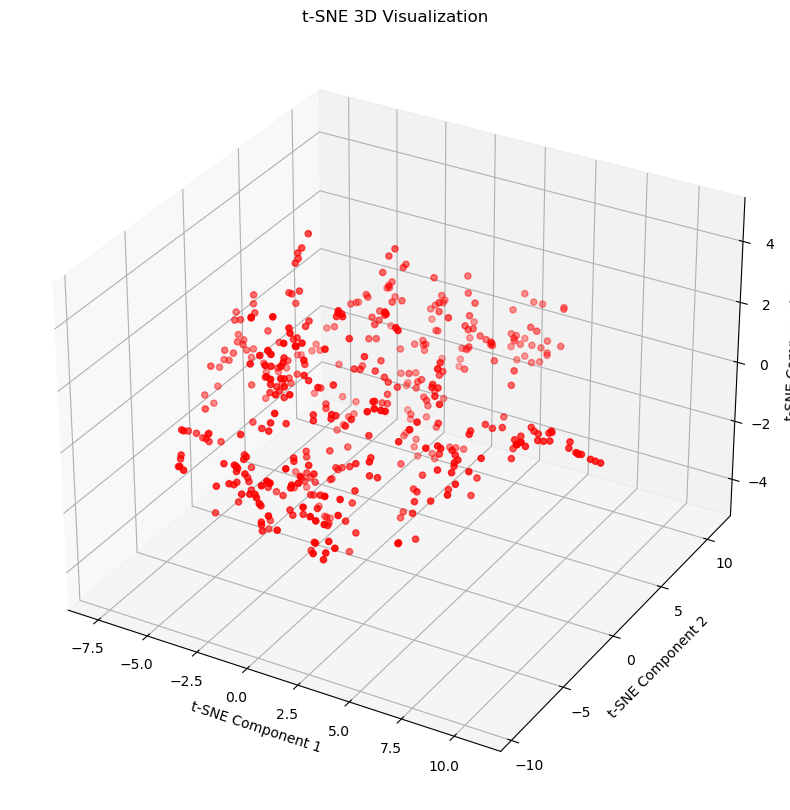

In [228]:
# Visualización 3D usando t-SNE
fig = plt.figure(figsize=(16,10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(tsne_result[:, 0], tsne_result[:, 1], tsne_result[:, 2], c='red', cmap='viridis')
ax.set_xlabel('t-SNE Component 1')
ax.set_ylabel('t-SNE Component 2')
ax.set_zlabel('t-SNE Component 3')
ax.set_title('t-SNE 3D Visualization')
plt.show()

usando ploty

In [229]:
import plotly.graph_objects as go


import numpy as np
np.random.seed(44)

tsne_result = np.random.rand(100, 3)  # Ejemplo con 100 puntos en 3D

# Crear la figura
fig = go.Figure(data=go.Scatter3d(
    x=tsne_result[:, 0],
    y=tsne_result[:, 1],
    z=tsne_result[:, 2],
    mode='markers',
    marker=dict(
        size=5,
        color='red',  # Color de los puntos
        opacity=0.8
    )
))

# Configurar los ejes y el título
fig.update_layout(
    title='t-SNE 3D Visualization',
    scene=dict(
        xaxis_title='t-SNE Component 1',
        yaxis_title='t-SNE Component 2',
        zaxis_title='t-SNE Component 3',
    ),
    margin=dict(l=0, r=0, b=0, t=40)
)

# Mostrar la figura
fig.show()


Analizar la varianza explicada por cada componente principal en PCA 

In [230]:
#Analizar la varianza explicada por cada componente principal en PCA  

# Calcular la varianza explicada por cada componente principal
print(pca.explained_variance_ratio_)


[0.51207998 0.22719234 0.0526398 ]


### Análisis de Varianzas Explicadas 

#### 1. **Varianzas Explicadas en PCA**
Las varianzas explicadas por las componentes principales son las siguientes:
- **Primera componente principal**: \( 0.5121 \) (51.21%)
- **Segunda componente principal**: \( 0.2272 \) (22.72%)
- **Tercera componente principal**: \( 0.0526 \) (5.26%)

##### **Contribución acumulada**
- **Primera y segunda componentes**: \( 0.5121 + 0.2272 = 0.7393 \) (73.93%)
- **Todas las componentes principales juntas**: \( 0.5121 + 0.2272 + 0.0526 = 0.7919 \) (79.19%)

Esto indica que las primeras dos componentes explican la mayor parte de la variabilidad en los datos, siendo suficiente para capturar la estructura principal de los mismos.

Encontrar la dimensión óptima según PCA utilizando los métodos vistos en clases. 


In [231]:
umbral = 0.80

# Dimensión óptima
optimal_dim = np.argmax(np.cumsum(pca.explained_variance_ratio_) >= umbral) + 1
print(f"Dimensión óptima según varianza acumulada: {optimal_dim}")


Dimensión óptima según varianza acumulada: 1


### Discutir las diferencias entre PCA y t-SNE, y cómo se reflejan en las visualizaciones

PCA (Análisis de Componentes Principales) y t-SNE (t-Distributed Stochastic Neighbor Embedding) son técnicas de reducción de dimensionalidad con enfoques y objetivos diferentes. PCA es un método lineal que preserva las relaciones globales al capturar la máxima varianza en los datos mediante combinaciones lineales de las variables originales, lo que lo hace ideal para análisis reproducibles y exploraciones globales. Por otro lado, t-SNE es un método no lineal que se enfoca en preservar las relaciones locales, resaltando patrones y agrupamientos en datos complejos, pero a costa de la distorsión de las relaciones globales y una mayor demanda computacional. Mientras que PCA genera resultados consistentes y escala bien con grandes conjuntos de datos, t-SNE es más adecuado para visualizar clusters en datasets pequeños, aunque su componente estocástica puede hacer que los resultados varíen entre ejecuciones.








### Diferencias en la Visualización entre PCA y t-SNE

#### 1. Distribución de los Puntos
- **PCA**: Aunque los grupos se distingen, una distribución más dispersa a lo largo de los ejes principales, lo que refleja la maximización de la varianza global.  
  - En los gráficos correspondientes, se observa que los datos están ampliamente distribuidos, especialmente en el primer componente principal.
- **t-SNE**: Los puntos tienden a agruparse en configuraciones más compactas, evidenciando relaciones locales y similitudes entre observaciones.  
  - En los gráficos asociados, se aprecia una organización más delimitada y agrupamientos bien definidos.

#### 2. Rango de los Ejes
- **PCA**: Los ejes están escalados en función de la varianza explicada por cada componente principal, lo que puede generar rangos de valores amplios o pequeños dependiendo de los datos analizados.
- **t-SNE**: Los ejes carecen de un significado inherente, ya que se generan de manera abstracta para facilitar la visualización, manteniéndose dentro de un rango homogéneo y reducido.

#### 3. Clusters
- **PCA**: Dificulta la identificación de patrones o agrupamientos evidentes, ya que los puntos suelen estar distribuidos de manera más uniforme.  
  - En los gráficos, se percibe una disposición menos estructurada de los puntos.
- **t-SNE**: Facilita la identificación de agrupamientos al resaltar relaciones locales entre las observaciones.  
  - Los gráficos muestran una clara separación entre grupos, reflejando similitudes intrínsecas.

El análisis visual generado por **PCA** es adecuado para identificar patrones globales en los datos, priorizando la varianza explicada en cada componente principal. Por otro lado, **t-SNE** optimiza la percepción de relaciones locales entre observaciones, siendo especialmente útil para la identificación de agrupamientos en datos de alta dimensionalidad.


# Clustering

Importamos las librerias a utilizar en este apartado.

In [232]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score

from sklearn.decomposition import PCA

Aplicar las técnicas de Clustering (k-Means) sobre los datos originales y los datos con
dimensionalidad reducida. [15 puntos]

In [233]:
#Primero vamos a reducir los datos
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data)

#Ahora vamos a definir el numero de clusters iniciales
kmeans = KMeans(n_clusters=2, random_state=42)
clusters = kmeans.fit_predict(data_scaled)

#Y finalmente añadimos los clusters al dataframe original
data['Cluster'] = clusters

c:\Users\benji\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

c:\Users\benji\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.



Utilizar el Método del Codo y Silhouette Score para determinar el número óptimo de clusters. Puede
explorar otras métricas de evaluación de clusters. [15 puntos]

c:\Users\benji\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

c:\Users\benji\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.

c:\Users\benji\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

c:\Users\benji\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.

c:\Users\ben

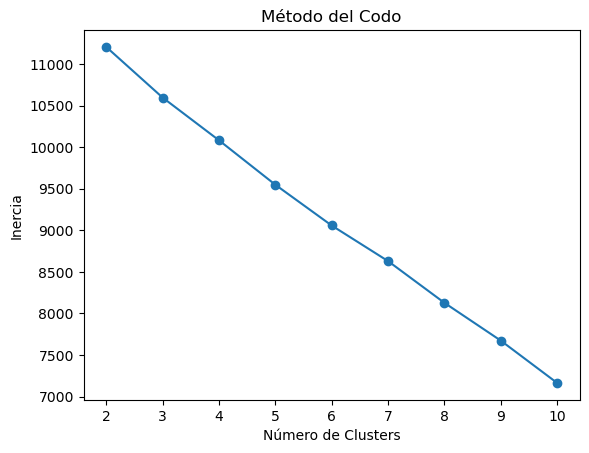

c:\Users\benji\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

c:\Users\benji\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.

c:\Users\benji\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

c:\Users\benji\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.

c:\Users\ben

Número de clusters: 2 | Silhouette Score: 0.1999698996930678
Número de clusters: 3 | Silhouette Score: 0.11155131665315567
Número de clusters: 4 | Silhouette Score: 0.0922969565979922
Número de clusters: 5 | Silhouette Score: 0.11809740600505537
Número de clusters: 6 | Silhouette Score: 0.132612852217693
Número de clusters: 7 | Silhouette Score: 0.1410691104335894
Número de clusters: 8 | Silhouette Score: 0.16650090571263157
Número de clusters: 9 | Silhouette Score: 0.18023194214485366
Número de clusters: 10 | Silhouette Score: 0.1833227492686104


c:\Users\benji\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

c:\Users\benji\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.

c:\Users\benji\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

c:\Users\benji\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.



In [234]:
#Realizaremos el metodo del codo, para eso almacenaremos
#las "inercias" dentro de una lista
inertia = []
#Vamos a comprobar el k desde 2 a 10
for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(data_scaled)
    inertia.append(kmeans.inertia_)

#Ahora mostramos el grafico obtenido con los clusters y sus inercias
plt.plot(range(2, 11), inertia, marker='o')
plt.xlabel('Número de Clusters')
plt.ylabel('Inercia')
plt.title('Método del Codo')
plt.show()

#Ahora haremos el Silhouette Score con los mismos kmeans
for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    clusters = kmeans.fit_predict(data_scaled)
    score = silhouette_score(data_scaled, clusters)
    #Vamos a imprimir cada silhouette score con su respectivo 
    #numero de clusters.
    print(f'Número de clusters: {k} | Silhouette Score: {score}')

Comparar y discutir los resultados obtenidos por los distintos algoritmos Visualizar los clusters obtenidos. [10 puntos]

Según los resultados obtenidos, podemos ver que el Método del Codo sugiere 6 clusters para capturar más subgrupos en los datos, sin embargo, el Silhouette Score muestra que el mayor puntaje fue obtenido con 2 Clusters, por lo que significa que la separación y cohesión son mejores que con cualquier otro número de clusters.
Osea que en conclusión, si se busca simplicidad, 2 Clusters, si se busca analizar a detalle, 6 Clusters.

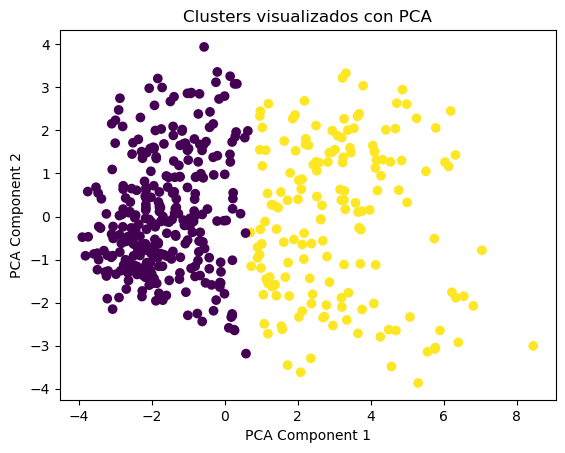

In [235]:
#Ahora vamos a reducir la dimensionalidad para la visualización
pca = PCA(n_components=2)
data_pca = pca.fit_transform(data_scaled)

#Y finalmente crearemos un scatter plot con los Clusters.
plt.scatter(data_pca[:, 0], data_pca[:, 1], c=data['Cluster'], cmap='viridis')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.title('Clusters visualizados con PCA')
plt.show()

## Interpretacion de los datos
Primero se mostraran los datos de los clusters

In [236]:
# Analisis de centroides
centroides_originales = scaler.inverse_transform(kmeans.cluster_centers_)

# Excluir columnas adicionales como 'Cluster' al crear nombres para los centroides
columnas_sin_cluster = data.columns[:-1]  # Todas las columnas excepto la última

# Crear DataFrame con los nombres de las columnas correctos
centroides_df = pd.DataFrame(centroides_originales, columns=columnas_sin_cluster)

print("\nCentroides de los clústeres:")
display(centroides_df)



Centroides de los clústeres:


,abv %,cost,# ratings,community rating,expert score,smoky,earthy,spicy,herbal,oily,...,type_MEZCAL AÑEJO,type_MEZCAL JOVEN,type_MEZCAL REPOSADO,type_RAICILLA,type_SOTOL,type_TEQUILA AÑEJO,type_TEQUILA BLANCO,type_TEQUILA EXTRA AÑEJO,type_TEQUILA JOVEN,type_TEQUILA REPOSADO
0,40.619277,3.180723,43.397590,4.107590,89.963855,13.301205,24.759036,37.048193,32.349398,15.867470,...,-1.734723e-18,2.775558e-16,3.469447e-18,-4.336809e-18,6.024096e-02,9.036145e-01,1.110223e-16,-8.326673e-17,3.614458e-02,8.326673e-17
1,47.018382,3.544118,30.176471,4.178971,91.617647,58.985294,58.426471,50.779412,65.426471,33.191176,...,5.204170e-18,9.705882e-01,3.469447e-18,-2.602085e-18,2.941176e-02,2.775558e-17,1.387779e-16,-5.551115e-17,5.204170e-18,1.387779e-16
2,45.252941,2.941176,19.205882,3.944118,89.397059,35.661765,34.264706,28.823529,39.382353,19.014706,...,-3.469447e-18,1.000000e+00,3.469447e-18,-2.602085e-18,-1.734723e-18,-8.326673e-17,1.387779e-16,-5.551115e-17,5.204170e-18,-5.551115e-17
3,41.154545,2.727273,17.181818,4.000909,89.090909,44.090909,40.727273,48.181818,35.181818,18.636364,...,-3.469447e-18,0.000000e+00,1.000000e+00,0.000000e+00,-1.734723e-18,-2.775558e-17,-2.775558e-17,0.000000e+00,0.000000e+00,-2.775558e-17
4,41.861111,2.208333,45.305556,4.009722,89.319444,4.263889,23.458333,27.513889,45.250000,16.305556,...,-3.469447e-18,2.775558e-16,3.469447e-18,-2.602085e-18,-3.469447e-18,-5.551115e-17,1.000000e+00,-5.551115e-17,6.938894e-18,0.000000e+00
5,41.379310,4.517241,28.620690,4.366897,92.482759,19.551724,32.241379,46.689655,34.724138,24.000000,...,-1.734723e-18,0.000000e+00,3.469447e-18,-1.734723e-18,0.000000e+00,-5.551115e-17,1.110223e-16,1.000000e+00,3.469447e-18,-5.551115e-17
6,40.393506,2.701299,37.064935,3.976623,88.727273,14.714286,23.623377,36.766234,34.454545,15.701299,...,1.734723e-18,2.775558e-16,0.000000e+00,-4.336809e-18,-1.040834e-17,0.000000e+00,1.665335e-16,-6.938894e-17,5.204170e-18,1.000000e+00
7,44.500000,3.333333,23.000000,3.856667,90.333333,43.333333,83.333333,40.000000,90.000000,55.000000,...,1.734723e-18,5.551115e-17,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.734723e-18,0.000000e+00
8,40.346154,2.576923,61.634615,4.086154,89.653846,33.961538,57.153846,68.903846,66.538462,54.826923,...,-3.469447e-18,0.000000e+00,0.000000e+00,-2.602085e-18,-1.734723e-18,3.076923e-01,3.461538e-01,3.846154e-02,1.923077e-02,2.884615e-01
9,41.083333,3.666667,20.833333,3.801667,92.333333,55.333333,42.500000,54.000000,23.500000,27.333333,...,1.000000e+00,5.551115e-17,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.734723e-18,0.000000e+00


Como se puede apreciar esos son los 10 clusters generados para usarse en K Means sin embargo aquellos que fueron utilizados para el grafico fueron el cluster 0 y el 1 ya que solo se utilizaron 2.
En cuanto a los clusters se puede apreciar que estos obtuvieron valores negativos en algunos tipos de tequila o mezcal esto puede deberse a que las caracteristicas (osea abv %, smoky,earthy,spicy,etc) no son compatibles con esos tipos de tequila mientras que en otros tipos se obtuvieron valores positivos por lo que es posible que sean compatibles con ese tipo y que tienen mayor probabilidad de ser el tipo con el valor mas alto.
Las caracteristicas que se pueden distinguir de cada cluster es que en el cluster 0 este posee altos valores de "Spicy" y de "Herbal" y bastante poco en "Oily" esto hace que sea mas compatible con el tipo "Tequila anejo", mientras que el cluster 1 posee altos valores en "Smoky", "Earthy" , "Herbal" y un "Oily" poco mayor al anterior haciendo que quede mas compatible con el tipo de "Mezcal Joven" esto tiene sentido ya que los valores altos de spicy tienden a ser un tipo de Tequila mientras que los valores de smoky tienden a ser un tipo de Mezcal.
Ya que cada cluster tiene a un tipo mas alto que el proedio los clusters podrian tener nombre de 0= Tequilas y 1=Mezcal por lo que los datos que esten cerca de estos cluster tenderan a corresponder al tipo de este.
Si la informacion obtenida de los cluster puede ser utilizada para analisis ya que estos pueden entregar etiquetas adicionales o inputs en un modelo de clasificacion mientras que estos pueden ayudar a mejorar la prediccion de variables en un modelo de regresion.


## Conclusion
El siguiente taller realizado se podria decir que es una "continuacion" del primero ya que se utiliza los mismos datos obtenidos con el webscrapping del primero solo que utilizando tecnicas de aprendizaje no supervisado vistas en la ultima unidad.
Dicho eso anteriormente el taller realizado se pudieron aplicar las tecnicas vistas en la clase aplicadas a set de datos mas complejo y amplio de aquellos utilizados en la clase demostrando un uso mas practico de estas.
### Clusters
El uso de k means para agrupar los datos se uso para revelar distintos patrones de agrupacion, en los resultados de el Metodo del codo y Silhouette Score, se obtubieron 10 clusters pero con este ultimo se recomendo usar solo 2 ya que es la manera mas simple si se quieren obtener resultados.
Gracias a los clusters que fueron utilizados se pudo observar la tendencia de los datos utilizados para saber si estos pertenecian a un grupo de Mezcal o a uno de Tequila.
Las ventajas de las tecnicas usadas son claras cuando se utilizan para buscar tendencias o patrones en grandes volumenes de datos pero de ahi viene su desventaja es que requiere de una interpretacion humana para ayudar a reconocer los patrones en los datos adquiridos por estas tecnicas

## Red neuronal

In [237]:
from sklearn.neural_network import MLPRegressor
from sklearn.neural_network import MLPClassifier
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score    
from sklearn.metrics import f1_score

se van a usar los datos para predecir el raiting de la comunidad

In [238]:
data = pd.read_csv("data.csv")

### MLPRegressor para regresion (Taller 1 - Regresion lineal)

In [239]:
X = data_cleaned.drop('community rating', axis=1)
y = data_cleaned['community rating']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#### Red neuronal con relu

In [240]:
mlp_Regresion_relu = MLPRegressor(
    hidden_layer_sizes=(100,),
    activation='relu',
    solver='adam',
    max_iter=300,
    random_state=42
)

In [241]:
mlp_Regresion_relu.fit(X_train, y_train)

MLPRegressor(max_iter=300, random_state=42)

#### Red neuronal con sigmoid

In [242]:
mlp_Regresion_sigmoid = MLPRegressor(
    hidden_layer_sizes=(100,),
    activation='logistic',
    solver='adam',
    max_iter=300,
    random_state=42
)

In [243]:
mlp_Regresion_sigmoid.fit(X_train, y_train)

c:\Users\benji\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.



MLPRegressor(activation='logistic', max_iter=300, random_state=42)

#### Red neuronal con tanh

In [244]:
mlp_Regresion_tanh = MLPRegressor(
    hidden_layer_sizes=(100,),
    activation='tanh',
    solver='adam',
    max_iter=300,
    random_state=42
)

In [245]:
mlp_Regresion_tanh.fit(X_train, y_train)

c:\Users\benji\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.



MLPRegressor(activation='tanh', max_iter=300, random_state=42)

#### Red neuronal con identity

In [246]:
mlp_Regresion_identity = MLPRegressor(
    hidden_layer_sizes=(100,),
    activation='identity',
    solver='adam',
    max_iter=300,
    random_state=42
)

In [247]:
mlp_Regresion_identity.fit(X_train, y_train)

MLPRegressor(activation='identity', max_iter=300, random_state=42)

##### Evaluacion de los modelos

In [248]:
y_pred_relu = mlp_Regresion_relu.predict(X_test)
y_pred_sigmoid = mlp_Regresion_sigmoid.predict(X_test)
y_pred_tanh = mlp_Regresion_tanh.predict(X_test)
y_pred_identity = mlp_Regresion_identity.predict(X_test)


In [249]:
print(f'R2 Score ReLU: {r2_score(y_test, y_pred_relu)}, MSE ReLU: {mean_squared_error(y_test, y_pred_relu)}')
print(f'R2 Score Sigmoid: {r2_score(y_test, y_pred_sigmoid)}, MSE Sigmoid: {mean_squared_error(y_test, y_pred_sigmoid)}')
print(f'R2 Score Tanh: {r2_score(y_test, y_pred_tanh)}, MSE Tanh: {mean_squared_error(y_test, y_pred_tanh)}')
print(f'R2 Score Identity: {r2_score(y_test, y_pred_identity)}, MSE Identity: {mean_squared_error(y_test, y_pred_identity)}')


R2 Score ReLU: -5.833670410689316, MSE ReLU: 1.4734322246342868
R2 Score Sigmoid: -0.06775615571522953, MSE Sigmoid: 0.23022274024534767
R2 Score Tanh: -0.890294670124236, MSE Tanh: 0.4075732239966987
R2 Score Identity: -0.5410183428891011, MSE Identity: 0.33226450043795647


Conclusión, son malisimo los modelos

### MLPClassifier para clasificacion (Taller 1 - Clasificación)

In [250]:
def etiquetar_ratings(df):
   
    df['label'] = pd.cut(df['community rating'], bins=[-float('inf'), 2.5, 3.5, float('inf')],
                             labels=['Negativo', 'Neutral', 'Positivo'])
    return df

In [251]:
data2 = data.copy()

In [252]:
data2['community rating'] = pd.to_numeric(data2['community rating'], errors='coerce')

data2 = etiquetar_ratings(data2)


In [253]:
data2.to_csv("data2.csv", index=False)

In [254]:
X = data2.drop(['community rating', 'label'], axis=1)
y = data2['label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

Red Neuronal de clasificacion con Relu

In [255]:
mlp_Classifier_relu = MLPClassifier(
    hidden_layer_sizes=(100,),
    activation='relu',
    solver='adam',
    max_iter=300,
    random_state=42
)

In [256]:
mlp_Classifier_relu.fit(X_train, y_train)

c:\Users\benji\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.



MLPClassifier(max_iter=300, random_state=42)

Red neuronal de clasificacion con Sigmoid

In [257]:
mlp_Classifier_sigmoid = MLPClassifier(
    hidden_layer_sizes=(100,),
    activation='logistic',
    solver='adam',
    max_iter=300,
    random_state=42
)

In [258]:
mlp_Classifier_sigmoid.fit(X_train, y_train)

c:\Users\benji\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.



MLPClassifier(activation='logistic', max_iter=300, random_state=42)

Red neuronal de clasificacion con tanh

In [259]:
mlp_Classifier_tanh = MLPClassifier(
    hidden_layer_sizes=(100,),
    activation='tanh',
    solver='adam',
    max_iter=300,
    random_state=42
)

In [260]:
mlp_Classifier_tanh.fit(X_train, y_train)

c:\Users\benji\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.



MLPClassifier(activation='tanh', max_iter=300, random_state=42)

Red neuronal de clasificacion con identity

In [261]:
mlp_Classifier_identity = MLPClassifier(
    hidden_layer_sizes=(100,),
    activation='identity',
    solver='adam',
    max_iter=300,
    random_state=42
)

In [262]:
mlp_Classifier_identity.fit(X_train, y_train)

MLPClassifier(activation='identity', max_iter=300, random_state=42)

In [263]:
y_pred_relu = mlp_Classifier_relu.predict(X_test)
y_pred_sigmoid = mlp_Classifier_sigmoid.predict(X_test)
y_pred_tanh = mlp_Classifier_tanh.predict(X_test)
y_pred_identity = mlp_Classifier_identity.predict(X_test)


In [264]:

print(f'F1 Score ReLU: {f1_score(y_test, y_pred_relu, average="weighted")}')
print(f'F1 Score Sigmoid: {f1_score(y_test, y_pred_sigmoid, average="weighted")}')
print(f'F1 Score Tanh: {f1_score(y_test, y_pred_tanh, average="weighted")}')
print(f'F1 Score Identity: {f1_score(y_test, y_pred_identity, average="weighted")}')


F1 Score ReLU: 0.8616146622084276
F1 Score Sigmoid: 0.8655966156526067
F1 Score Tanh: 0.8612505018065034
F1 Score Identity: 0.8565234845443596
